**PACKAGES**

In [125]:
import pystac_client
import planetary_computer
import rasterio as rio
import rasterio.mask
from matplotlib import pyplot as plt
import numpy as np
import rich
import pandas as pd
import xarray as xr
import stackstac
from IPython.display import display
import geopandas as gpd
import rioxarray
from rasterio import features
import time
import rasterstats
from mpl_toolkits.axes_grid1 import make_axes_locatable

**AREA OF INTEREST**

In [126]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    )

item = catalog.get_collection('sentinel-2-l2a').get_item("S2A_MSIL2A_20230812T232631_R044_T58MGE_20230813T031719")

aoi_bounds = [166.912811, -0.556273, 166.958823, -0.495027]
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12']
FILL_VALUE = 2**16-1

ds = stackstac.stack(
                    item,
                    assets = bands,
                    resolution=10,
                    dtype="uint16",
                    fill_value=FILL_VALUE,
                    bounds_latlon=aoi_bounds,
                    )

ds

<xarray.DataArray 'stackstac-7978f523db44861e30e2b18f23b287ba' (time: 1,
                                                                band: 9,
                                                                y: 679, x: 514)>
dask.array<fetch_raster_window, shape=(1, 9, 679, 514), dtype=uint16, chunksize=(1, 1, 679, 514), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2023-08-12...
    id                                       (time) <U54 'S2A_MSIL2A_20230812...
  * band                                     (band) <U3 'B02' 'B03' ... 'B12'
  * x                                        (x) float64 7.129e+05 ... 7.18e+05
  * y                                        (y) float64 9.945e+06 ... 9.938e+06
    s2:generation_time                       <U27 '2023-08-13T03:17:19.350166Z'
    ...                                       ...
    gsd                                      (band) float64 10.0 10.0 ... 20.0
    title                                    (band) <U36 'Band 2 - Blue - 10m...
    common_name                              (band) <U7 'blue' ... 'swir22'
    center_wavelength                        (band) float64 0.49 0.56 ... 2.19
    full_width_half_max                      (band) float64 0.098 ... 0.242
    epsg                                     int32 32758
Attributes:
    spec:        RasterSpec(epsg=32758, bounds=(712870, 9938470, 718010, 9945...
    crs:         epsg:32758
    transform:   | 10.00, 0.00, 712870.00|\n| 0.00,-10.00, 9945260.00|\n| 0.0...
    resolution:  10

**SLICING**

In [127]:
#ds.sel(x=slice(712900, 717980), y=slice(9938500, 9945200))

**INDEXES**

In [128]:
nir = ds.sel(band="B08").astype('float')
swir = ds.sel(band="B11").astype('float')
red = ds.sel(band="B04").astype('float')
green = ds.sel(band="B03").astype('float')
rededge = ds.sel(band="B05").astype('float')
blue = ds.sel(band="B02").astype('float')

#Chlorophyll vegetation index
cvi = nir*red/green**2
#Global vegetation moisture index
gvmi = ((nir+0.1)-(swir+0.02))/((nir+0.1)+(swir+0.02))
#Blue-wide dynamic range vegetation index
bwdrvi = (0.1*nir-blue)/(0.1*nir+blue)

**COLOURED COMPOSITE**

In [131]:
cvi_np=cvi.to_numpy()
gvmi_np=gvmi.to_numpy()
bwdrvi_np=bwdrvi.to_numpy()
evi_np=evi.to_numpy()

def normalize(array, vmax=False):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    if vmax:
        array[array>vmax] = vmax
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

cvi_n = normalize(cvi_np)
gvmi_n = normalize(gvmi_np)
bwdrvi_n = normalize(bwdrvi_np)

rgb = np.stack((cvi_n, gvmi_n, bwdrvi_n))
rgb_natcol = np.moveaxis(rgb.squeeze(), 0, -1)

RuntimeError: Error opening 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/58/M/GE/2023/08/12/S2A_MSIL2A_20230812T232631_N0509_R044_T58MGE_20230813T031719.SAFE/GRANULE/L2A_T58MGE_A042512_20230812T232627/IMG_DATA/R10m/T58MGE_20230812T232631_B02_10m.tif?st=2023-08-14T11%3A42%3A59Z&se=2023-08-15T12%3A27%3A59Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-08-15T11%3A21%3A45Z&ske=2023-08-22T11%3A21%3A45Z&sks=b&skv=2021-06-08&sig=QQcWZPzpfDi8miaTWNrwTSP4ER/NjIJOpZcBnZ1pKvM%3D': RasterioIOError("'/vsicurl/https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/58/M/GE/2023/08/12/S2A_MSIL2A_20230812T232631_N0509_R044_T58MGE_20230813T031719.SAFE/GRANULE/L2A_T58MGE_A042512_20230812T232627/IMG_DATA/R10m/T58MGE_20230812T232631_B02_10m.tif?st=2023-08-14T11%3A42%3A59Z&se=2023-08-15T12%3A27%3A59Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-08-15T11%3A21%3A45Z&ske=2023-08-22T11%3A21%3A45Z&sks=b&skv=2021-06-08&sig=QQcWZPzpfDi8miaTWNrwTSP4ER/NjIJOpZcBnZ1pKvM%3D' not recognized as a supported file format.")

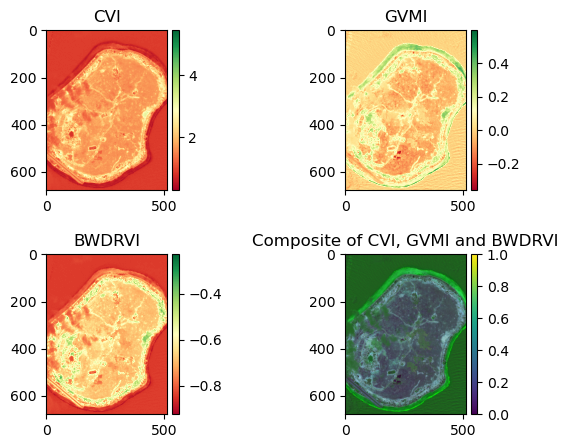

In [130]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(cvi.squeeze(), cmap="RdYlGn")
axs[0, 0].title.set_text('CVI')
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(axs[0, 0].imshow(cvi.squeeze(), cmap="RdYlGn"), cax=cax, orientation='vertical')

axs[0, 1].imshow(gvmi.squeeze(), cmap="RdYlGn")
axs[0, 1].title.set_text('GVMI')
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(axs[0, 1].imshow(gvmi.squeeze(), cmap="RdYlGn"), cax=cax, orientation='vertical')

axs[1, 0].imshow(bwdrvi.squeeze(), cmap="RdYlGn")
axs[1, 0].title.set_text('BWDRVI')
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(axs[1, 0].imshow(bwdrvi.squeeze(), cmap="RdYlGn"), cax=cax, orientation='vertical')

axs[1, 1].imshow(rgb_natcol)
axs[1, 1].title.set_text('Composite of CVI, GVMI and BWDRVI')
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(axs[1, 1].imshow(rgb_natcol), cmap="RdYlGn", cax=cax, orientation='vertical')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.show()
